# **Ciudad de Mexico Airbnb EDA**

## **Introduction**

[InsideAirbnb](https://insideairbnb.com) is a project which scrapes real airbnb listings for the purpose of analysis and advocacy. Airbnb claims to be part of the "sharing economy" and disrupting the hotel industry. However, data shows that the majority of Airbnb listing in most cities are entire homes, many of which are rented all year round - disruptiong housing and commuities.

The main question i want to answer is:
### **How is Airbnb really being used in and affecting the neighbourhoods of CDMX?**

Structured question tree:
- descriptive->diagnostic->predictive->prescriptive

Let's breakdown the question into smaller subquestions:

**Inventory & Distribution**
- How many Airbnb listings exists in CDMX, and how are they distributed geograpically
- Which colonias have the highest density of listings
- What % of housing inventory in each colonia is Airbnb vs. long-term residential units?
- What's the distribution of room types?

**Behavious & Usage**
- What % of hosts have multiple listings (professional operators) vs. single-unit hosts?
- Which neighbourhoods have the highest share of multi-property hosts?
- What % of hosts are foreing vs. nationals
- Are listings primarily short-stay (<7 days) or long-stay (>28 days) oriented?

**Occupancy & Demand**
- What are average occuncy rates by colonia?
- What is seasonal demand like (high and low months)?
- What is the average lenght of stay by neighbourhood?

**Pricing**
- What are nightly prices by area?
- How have prices changed YoY?
- Are Airbnb prices correlated with tourism hotspots or metro accessibility?

**Housing Market**
- Do colonias with high Airbnb density also show higher increases in ernt prices (INEGI rent/rate data)
- Correlation between Airbnb listing growth and:
    - rent increases
    - % residents reporting household displacement (if i find it)

**Local Economy**
- Estimated Airbnb revenue injected into each colonia - Where does the money go?
    - % captured by foreing / non-local operators
    - potential "leakage" where hosts do not reside locally
- Are neighbourhood with high Airbnb density seeing:
    - growth in restaurants/cafés (openings)
    - drop in local traditional commerce?

#### **Social & Urban-Fabric Questions**
- Are neighborhoods with high Airbnb use experiencing demographic shifts (proxy metrics: long-stay pricing, English-language listing share)
- Which colonias show a mismatch between resident population size and number of active short-term rentals?
- Are there signs of "Airbnb-driven tourism corridors" (Roma -> Condesa -> Juarez, etc.)?

#### **Spatial Questions (dashboards + maps)**
- Heatmap: Listings per hectare by colonia
- Which Airbnb clusters appear near:
    - metro stations
    - parks
    - tourist attractions
    - coworking spaces
- Are listing clusters expanding over time?

#### **Strategic / Policy-Oriented Questions**
- Should regulations limit multi-listing hosts in CDMX?
- Which olonias are at highest risk of displacement?
- Where could Airbnb be redirected to boost tourism in under-visited districts?

**Datasets**
- listings.csv.gz: Detailed listings data
- listings.csv: Summary information and metrics for listings in Mexico City (good for visualisations).
- calendar.csv.gz: Detailed calendar data
- reviews.csv.gz: Detailed review data
- reviews.csv: Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).
- neighbourhoods.csv: Neighbourhood list for geo filter. Sourced from city or open source GIS files.
- neighbourhoods.geojson: GeoJSON file of neighbourhoods of the city.
- INEGI housing / rent data (for correlation)
- SEDECO economic statistics (local businesses)

In [1]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np # Linear algebra
import pandas as pd # Data manipulation
import matplotlib.pyplot as plt # Plots
import seaborn as sns # More plots
import folium # Geospatial visualizations
from folium.features import GeoJsonTooltip # For colormap labels
import requests # Fetching GeoJson data
import branca.colormap as cm # For creating colormaps

datasetpath = "./dataset/"

In [2]:
listings = pd.read_csv(datasetpath + "listings.csv.gz")
listings_raw = listings.copy() # Keeping raw copy
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27051 entries, 0 to 27050
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            27051 non-null  int64  
 1   listing_url                                   27051 non-null  object 
 2   scrape_id                                     27051 non-null  int64  
 3   last_scraped                                  27051 non-null  object 
 4   source                                        27051 non-null  object 
 5   name                                          27051 non-null  object 
 6   description                                   26309 non-null  object 
 7   neighborhood_overview                         13736 non-null  object 
 8   picture_url                                   27051 non-null  object 
 9   host_id                                       27051 non-null 

In [3]:
with pd.option_context('display.max_columns', None):
    print(listings.head(5).T)

                                                                               0  \
id                                                                         35797   
listing_url                                   https://www.airbnb.com/rooms/35797   
scrape_id                                                         20250927041820   
last_scraped                                                          2025-09-27   
source                                                               city scrape   
...                                                                          ...   
calculated_host_listings_count                                                 1   
calculated_host_listings_count_entire_homes                                    1   
calculated_host_listings_count_private_rooms                                   0   
calculated_host_listings_count_shared_rooms                                    0   
reviews_per_month                                                           

In [4]:
# Cleaning listings dataset
columms_to_drop = [
    "listing_url", "scrape_id", "last_scraped", "source", "picture_url",
    "host_url", "host_since", "host_response_time", "host_response_rate",
    "host_acceptance_rate", "host_is_superhost", "host_thumbnail_url" ,
    "host_picture_url", "host_has_profile_pic", "bathrooms", "bathrooms_text",
    "bedrooms", "beds", "amenities", "number_of_reviews",
    "number_of_reviews_ltm", "number_of_reviews_l30d",
    "first_review", "last_review", "review_scores_rating",
    "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin",
    "review_scores_communication", "review_scores_location", "review_scores_value",
    "instant_bookable", "neighbourhood_group_cleansed", "calendar_updated", "license",
    "host_verifications", "host_identity_verified", "has_availability", "reviews_per_month",
    "host_about", "neighborhood_overview", "description", "name",
    "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights",
    "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm"
]
listings.drop(columms_to_drop, axis=1, inplace=True)

In [5]:
listings.columns

Index(['id', 'host_id', 'host_name', 'host_location', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object')

In [6]:
listings.describe(include="all")

,id,host_id,host_name,host_location,host_neighbourhood,host_listings_count,host_total_listings_count,neighbourhood,neighbourhood_cleansed,latitude,...,availability_365,calendar_last_scraped,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
count,2.705100e+04,2.705100e+04,27045,21224,14787,27045.000000,27045.000000,13736,27051,27051.000000,...,27051.000000,27051,27051.000000,27051.000000,27051.000000,2.356700e+04,27051.000000,27051.000000,27051.000000,27051.000000
unique,NaN,NaN,4299,412,1127,NaN,NaN,283,16,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Alejandro,"Mexico City, Mexico",Polanco,NaN,NaN,"Mexico City, Mexico",Cuauhtémoc,NaN,...,NaN,2025-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,388,17344,1658,NaN,NaN,12360,12514,NaN,...,NaN,19794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.003556e+17,2.429439e+08,NaN,NaN,NaN,24.604807,33.771640,NaN,NaN,19.405490,...,232.686333,NaN,56.830062,12.850357,84.031977,1.248591e+05,14.559868,11.351188,2.906547,0.263613
std,5.702714e+17,2.062579e+08,NaN,NaN,NaN,81.409257,116.146348,NaN,NaN,0.042390,...,122.270858,NaN,33.143405,21.084864,90.197039,2.126594e+05,31.892178,31.169010,8.139586,2.250202
min,3.579700e+04,7.365000e+03,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,19.177848,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
25%,4.410472e+07,5.621443e+07,NaN,NaN,NaN,1.000000,2.000000,NaN,NaN,19.392489,...,140.000000,NaN,31.000000,0.000000,0.000000,7.020000e+03,1.000000,0.000000,0.000000,0.000000
50%,8.307368e+17,1.766835e+08,NaN,NaN,NaN,4.000000,6.000000,NaN,NaN,19.415390,...,269.000000,NaN,65.000000,3.000000,48.000000,5.767200e+04,3.000000,1.000000,0.000000,0.000000
75%,1.217382e+18,4.288830e+08,NaN,NaN,NaN,15.000000,18.000000,NaN,NaN,19.432015,...,341.000000,NaN,87.000000,19.000000,150.000000,1.685620e+05,11.000000,6.000000,2.000000,0.000000


In [7]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27051 entries, 0 to 27050
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            27051 non-null  int64  
 1   host_id                                       27051 non-null  int64  
 2   host_name                                     27045 non-null  object 
 3   host_location                                 21224 non-null  object 
 4   host_neighbourhood                            14787 non-null  object 
 5   host_listings_count                           27045 non-null  float64
 6   host_total_listings_count                     27045 non-null  float64
 7   neighbourhood                                 13736 non-null  object 
 8   neighbourhood_cleansed                        27051 non-null  object 
 9   latitude                                      27051 non-null 

In [8]:
# Dropping neighbourhood since cleansed column already exists
listings.drop("neighbourhood", axis=1, inplace=True)
listings.rename(columns={"neighbourhood_cleansed":"neighbourhood"}, inplace=True)

In [9]:
# Setting price column to float
listings["price"] = listings["price"].str.replace(r"[^0-9.]", "", regex=True).astype("float64")

In [10]:
# Setting up folium map
def fresh_map():
    cdmx_map = folium.Map(
        location=(19.3800, -99.1332),
        zoom_start=10,
        tiles="Cartodb Positron"
    )

    return cdmx_map

cdmx_map = fresh_map()

# neighbourhoods GeoJson data
geojson_data = requests.get(
    "https://data.insideairbnb.com/mexico/df/mexico-city/2025-09-27/visualisations/neighbourhoods.geojson"
).json()


### **Inventory & Distribution**

- How many Airbnb listings exists in CDMX, and how are they distributed geograpically?

In [11]:
listings_neigh_counts = listings["neighbourhood"].value_counts()

print("Amount of listings in CDMX is:", listings_neigh_counts.sum())

Amount of listings in CDMX is: 27051


In [12]:
cdmx_map = fresh_map()

choropleth = folium.Choropleth(
    geo_data=geojson_data,
    data=listings_neigh_counts,
    columns=['neighbourhood', 'count'],
    key_on='feature.properties.neighbourhood',
    fill_color="YlOrRd",
    legend_name="Airbnb listings count by neigbourhood"
).add_to(cdmx_map)

for feature in geojson_data['features']:
    name = feature['properties']['neighbourhood']
    feature['properties'].update({'count': int(listings_neigh_counts[name])})

folium.features.GeoJsonTooltip(
    fields=['neighbourhood', 'count'],
    aliases=['Neighbourhood:', 'Listings:'],
    localize=True,
    sticky=False,
    labels=True,
    style=("""
        background-color: white;
        color: black;
        font-family: monospace;
        font-size: 12px;
        padding: 10px;
    """),
).add_to(choropleth.geojson)

cdmx_map

- Which colonias have the highest density of listings?

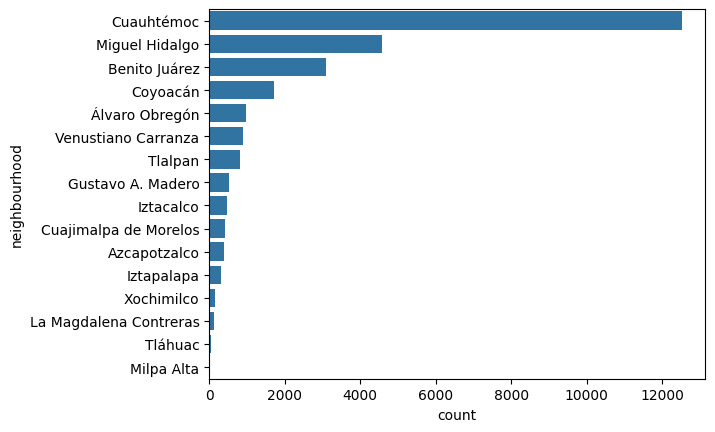

In [13]:
sns.barplot(data=listings_neigh_counts, orient="h");

- What % of housing inventory in each colonia is Airbnb vs. long-term residential units?

According to Encuesta Nacional de Ingresos y Gastos de los Hogares 2024 (ENIGH). The total number of long-term housing in La Ciudad de Mexico is of 3,029,724. Despite the quantity of Airbnbs in the city only representing 0.89% of total houses. We cannot conclude anything meaningful without direct neighbourhood data.
 

- What's the distribution of room types?

<Axes: ylabel='room_type'>

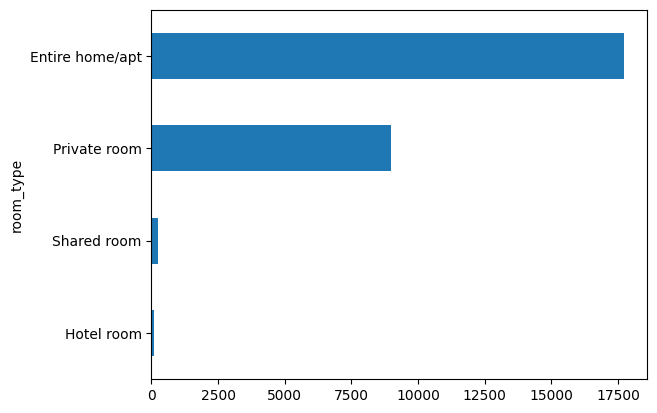

In [14]:
listings.room_type.value_counts(ascending=True).plot.barh()

**Distribution of room type by neighbourhood**

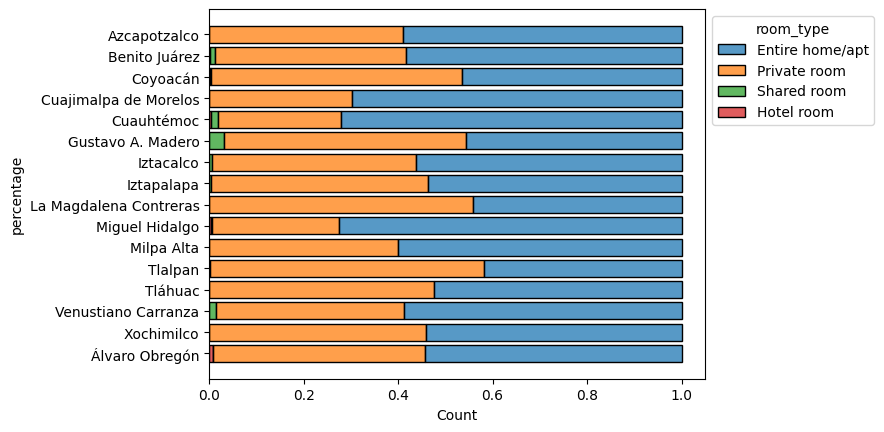

In [106]:
room_type_share = listings.groupby("neighbourhood").room_type.value_counts()

for name in listings.neighbourhood.unique():
    room_type_share[name] = room_type_share[name] / room_type_share[name].sum()

# Visualizing room type share by neighbourhood
pd.DataFrame(room_type_share)

# One liner to create a stacked bar chart.
ax = sns.histplot(pd.DataFrame(room_type_share),
                  y='neighbourhood', hue='room_type',
                  weights='count', multiple='stack',
                  shrink=0.8,)
ax.set_ylabel('percentage')

# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))

### **Behavious & Usage**

- What % of hosts have multiple listings (professional operators) vs. single-unit hosts?

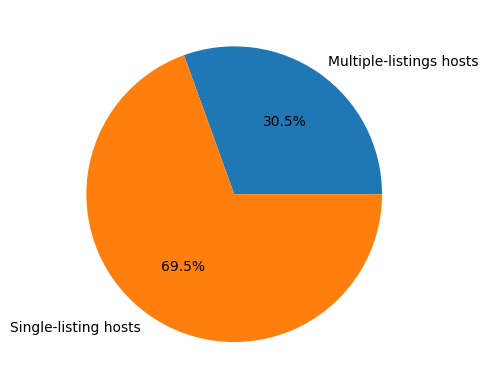

In [15]:
host_listing_counts = listings.groupby("host_id").size()

host_groups = {
    "Multiple-listings hosts": (host_listing_counts > 1).sum(),
    "Single-listing hosts": (host_listing_counts == 1).sum()
}

fig, ax = plt.subplots()
ax.pie(host_groups.values(), labels=host_groups.keys(), autopct="%1.1f%%");

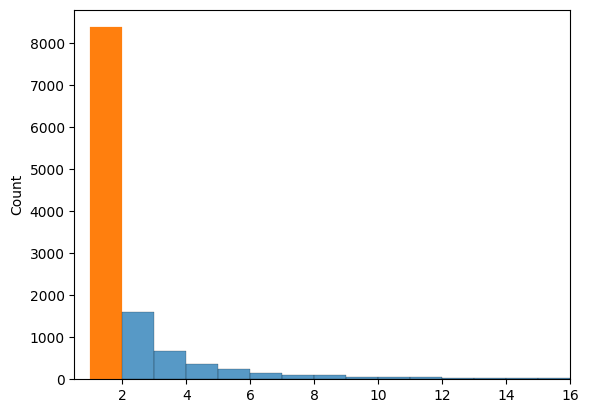

In [16]:
hist = sns.histplot(data=host_listing_counts)
plt.xlim(0.5, 16)
hist.patches[0].set_color(sns.color_palette("tab10")[1])
plt.show()

- Which neighbourhoods have the highest share of multi-property hosts?

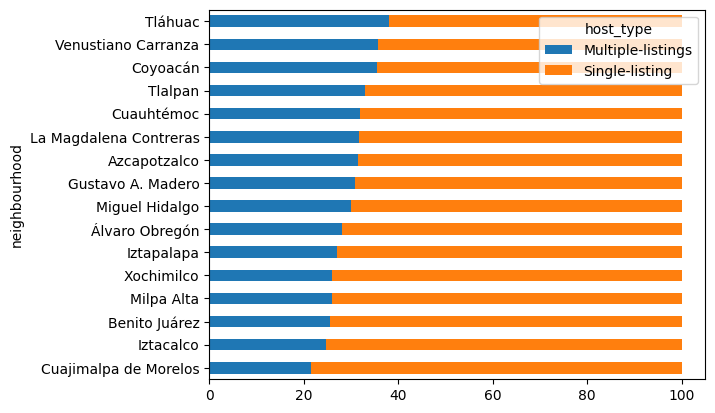

In [17]:
# Temporary dataframe
hosts = (listings[['host_id', 'neighbourhood']].drop_duplicates('host_id'))

# Map new column by the amount of listings a host has
hosts['host_type'] = hosts['host_id'].map(
    lambda x: 'Single-listing' if host_listing_counts[x] == 1 else 'Multiple-listings'
)

# Count the groups
hosts_by_neighbourhood = (
    hosts.groupby(['neighbourhood', 'host_type']).size().unstack(fill_value=0)
)

# Change to percents 
pct_by_neighbourhood = (
    hosts_by_neighbourhood.div(hosts_by_neighbourhood.sum(axis=1), axis=0) * 100
)

# Sort by the sum of the multiple-listings
pct_by_neighbourhood.sort_values(
    by='Multiple-listings',
    ascending=True,
    inplace=True
)

pct_by_neighbourhood.plot(
    kind='barh',
    stacked=True,
    
);

- What % of hosts are foreing vs. nationals

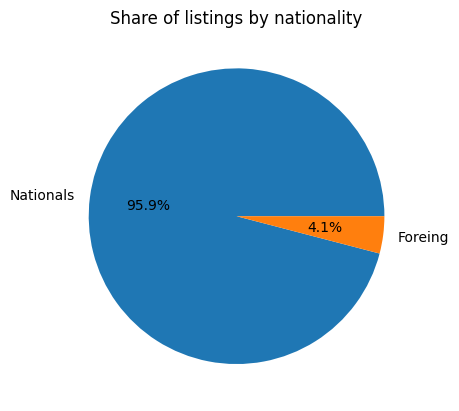

In [18]:
hosts_locations = listings.host_location.dropna()
nationals_filter = hosts_locations.str.contains("Mex")

foreing = len(hosts_locations[~nationals_filter])
nationals = len(nationals_filter)

fig, ax = plt.subplots()
ax.pie([nationals, foreing], labels=['Nationals', 'Foreing'], autopct="%1.1f%%")
plt.title('Share of listings by nationality');

- Are listings primarily short-stay (<7 days) or long-stay (>28 days) oriented?

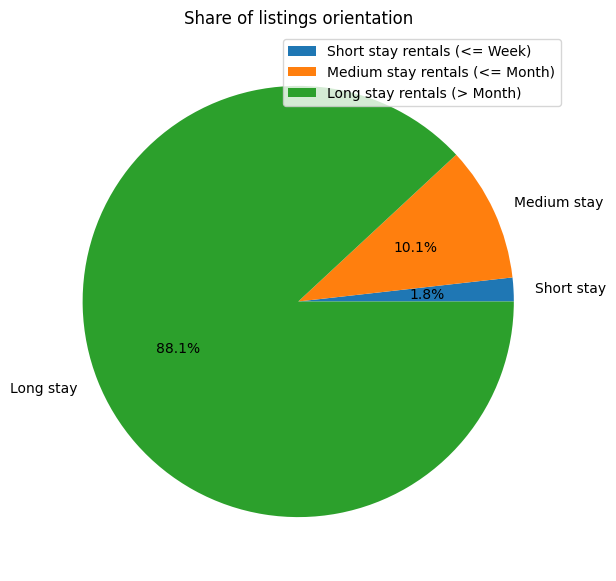

In [19]:
short_stay = len(listings[listings.maximum_nights <= 7])
medium_stay = len(listings[listings.maximum_nights <= 30]) - short_stay
long_stay = len(listings.maximum_nights) - medium_stay - short_stay

fig, ax = plt.subplots(figsize=(12,7))
ax.pie([short_stay, medium_stay, long_stay], labels=['Short stay', 'Medium stay', 'Long stay'], autopct="%1.1f%%")
ax.legend(
    ["Short stay rentals (<= Week)", "Medium stay rentals (<= Month)", "Long stay rentals (> Month)"],
    loc=1
)
plt.title('Share of listings orientation');

### **Occupancy & Demand**

- What are average occuncy rates by colonia?

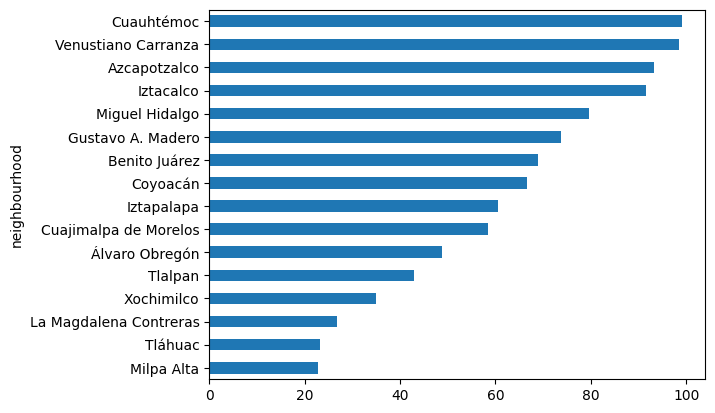

In [20]:
listings.groupby("neighbourhood").estimated_occupancy_l365d.mean().sort_values().plot.barh();

- What is seasonal demand like (high and low months)?

**To answer this question i would need time series data on availability. The data scrapped is a snapshot of listings state.**

- What is the average lenght of stay by neighbourhood?

**A rough estimation of length of stay can be done using "number_of_reviews_ly" and the "estimated_occupancy_l365d". Assuming that each guest gave one review and that the "number_of_reviews_ly" column means last 365 days.**

**I can estimate the average vacancy of each listing in the next 3 months from the date of being scraped**

In [21]:
# First let's get an idea of how often a guest leaves a review to see if an estimation is worth doing
# First we remove all listings that werent occupied last year
listings_occupied_ly = listings[["estimated_occupancy_l365d","number_of_reviews_ly"]].loc[(listings.estimated_occupancy_l365d != 0)]

# Now we count the amount listings that do have at least 1 review
n_reviewed_listings = len(listings_occupied_ly.loc[(listings_occupied_ly.number_of_reviews_ly != 0)])

# Now we calculate the amount of listings with a review
print(f"{((n_reviewed_listings / len(listings_occupied_ly))*100):.1f} % of listings that were occupied at least 1 day received a review last year")

76.9 % of listings that were occupied at least 1 day received a review last year


This suggests that reviews are common enough to be informative. That being said, there are some caveats to the assumption:
- Some guests leave no reviews
- Some listings receive multiple reviews for short stays
- Longer stays do not generate more reviews

So the estimation is more correlated to number of stays and not with length of stay

Some more implicit assumptions are being done here, like:
1. Review rate is constant
2. Review rate is independent of stay length
3. Review behavior doesn't depend on price, location, host type
4. Occupancy days are accurately estimated
5. Reviews in last 365 days correspond exactly to stays in those 365 days

So, with that in mind what we are more accurately estimating is **Average occupied days per review** which is a proxy for average stay length

In [22]:
def days_per_review(row):
    # Calculates the days per review of a listing
    if not row["estimated_occupancy_l365d"] or not row["number_of_reviews_ly"]:
        return np.nan
    else:
        return round((row["estimated_occupancy_l365d"] / row["number_of_reviews_ly"]), 2)

listings["estimated_days_per_review"] = listings.apply(days_per_review, axis=1)

In [23]:
listings.groupby("neighbourhood").estimated_days_per_review.mean().sort_values()

neighbourhood
Milpa Alta                 7.827692
Iztacalco                  9.045575
Gustavo A. Madero          9.497196
Tláhuac                    9.677368
Coyoacán                   9.685953
Benito Juárez             10.745221
Álvaro Obregón            10.898077
Azcapotzalco              10.914100
Cuauhtémoc                11.032972
Tlalpan                   11.114314
Venustiano Carranza       11.205590
Cuajimalpa de Morelos     11.224877
Miguel Hidalgo            11.776475
Iztapalapa                11.917863
La Magdalena Contreras    11.953600
Xochimilco                14.620545
Name: estimated_days_per_review, dtype: float64

In [24]:
estimated_days_per_review = listings_occupied_ly.estimated_occupancy_l365d.mean() / listings_occupied_ly.number_of_reviews_ly.mean()
print(f"Average estimated days per review is: {estimated_days_per_review:.2f}")

Average estimated days per review is: 6.61


In [25]:
(listings.groupby("neighbourhood").estimated_occupancy_l365d.mean() / listings.groupby("neighbourhood").number_of_reviews_ly.mean()).sort_values()

neighbourhood
Venustiano Carranza       5.388939
Azcapotzalco              6.051140
Coyoacán                  6.229857
Gustavo A. Madero         6.252472
Milpa Alta                6.333333
Miguel Hidalgo            6.536713
Cuauhtémoc                6.600442
Benito Juárez             6.683870
Cuajimalpa de Morelos     6.694374
Iztacalco                 6.865423
Tlalpan                   6.966593
Álvaro Obregón            7.035582
La Magdalena Contreras    7.074570
Tláhuac                   7.781513
Iztapalapa                8.151718
Xochimilco                8.640127
dtype: float64

- **Average vacancy of listings in the next 3 months from the date of being scraped**

In [26]:
# Date of being scraped
listings_raw.last_scraped.value_counts().index[:]

Index(['2025-09-28', '2025-09-27'], dtype='object', name='last_scraped')

<Axes: ylabel='neighbourhood'>

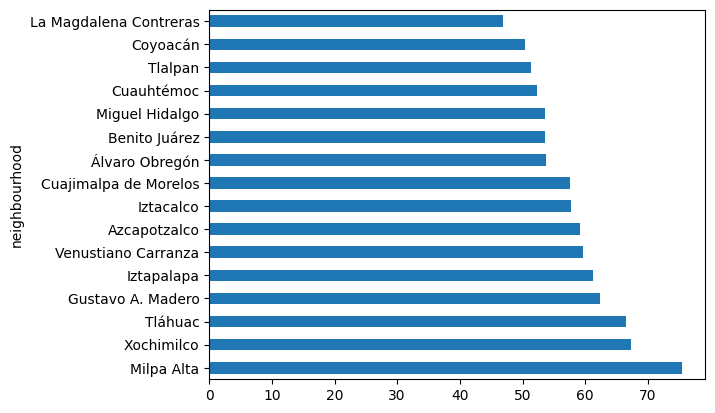

In [27]:
listings.groupby("neighbourhood").availability_90.mean().sort_values(ascending=False).plot.barh()

### **Pricing**

- What are nightly prices by area?

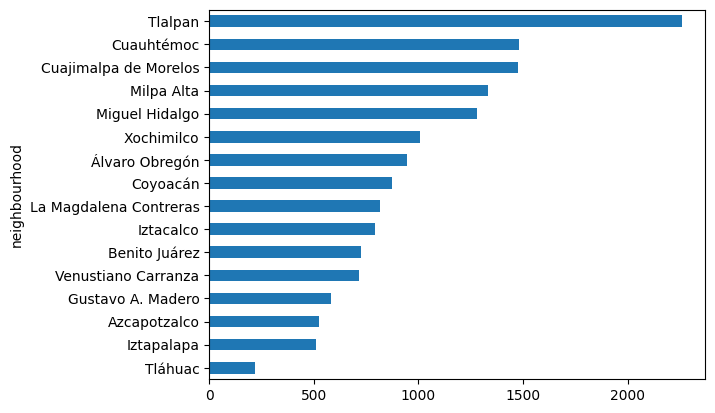

In [32]:
# Pricing shown from airbnb website depend on the minimum nights assigned by
# the host
listings["nightly_prices"] = listings.price / listings.minimum_nights

listings.groupby("neighbourhood").nightly_prices.mean().sort_values().plot.barh()

In [46]:
# Let's visualize the nightly prices
neighbourhood_nightly_prices = listings.groupby("neighbourhood").nightly_prices.mean().sort_values(ascending=False)

def visualize_neighbourhood_choropleth_CDMX(data_series, legend="", value_alias="Value"):    
    
    cdmx_map = fresh_map()
    
    choropleth = folium.Choropleth(
        geo_data = geojson_data,
        data = data_series,
        columns = ['neighbourhood', 'count'],
        key_on = 'feature.properties.neighbourhood',
        fill_color = "YlOrRd",
        legend_name = legend
    ).add_to(cdmx_map)
    
    for feature in geojson_data['features']:
        name = feature['properties']['neighbourhood']
        feature['properties'].update({'count': int(data_series[name])})
    
    folium.features.GeoJsonTooltip(
        fields = ['neighbourhood', 'count'],
        aliases = ['Neighbourhood:', value_alias],
        localize = True,
        sticky = False,
        labels = True,
        style=("""
            background-color: white;
            color: black;
            font-family: monospace;
            font-size: 12px;
            padding: 10px;
        """),
    ).add_to(choropleth.geojson)
    
    return cdmx_map

visualize_neighbourhood_choropleth_CDMX(neighbourhood_nightly_prices, legend="Nightly prices", value_alias="Prices")

Interestingly enough tlalpan nightly prices are peculiarly high. Even though their share of entire homes/apts being listed is the lowest one.

- Are Airbnb prices correlated with tourism hotspots or metro accessibility?

- What correlates to the nightly prices

Lets prepare the data for a correlation analysis. 

In [120]:
# First lets take out the features we dont want to analyse 
corr_df = listings.drop(listings.columns[[1, 2, 3, 4, 5, 6, 10, 20]], axis=1)

# Now we turn categorical values into quantitative ones using dummies by one-hot encoding
#pd.get_dummies

### **Housing Market**
- Do colonias with high Airbnb density also show higher increases in ernt prices (INEGI rent/rate data)
- Correlation between Airbnb listing growth and:
    - rent increases
    - % residents reporting household displacement (if i find it)

### **Local Economy**
- Estimated Airbnb revenue injected into each colonia - Where does the money go?
    - % captured by foreing / non-local operators
    - potential "leakage" where hosts do not reside locally
- Are neighbourhood with high Airbnb density seeing:
    - growth in restaurants/cafés (openings)
    - drop in local traditional commerce?